<a href="https://colab.research.google.com/github/roanbrasil/MGL869-IA/blob/main/MGL869_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'intel-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111880%2F269359%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T204253Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D160270482cc4fc244da57405832e0e0ee6d2fc9b247ca73e586f303ddc90d286a4b9564edaff08d7f2578f0f49a41144f5a06259bcf6681a28979125beac101868dd2d9d33a502bfa6428a5724564cb77bd2d2e8e10533b3ca45fb6e436856d4e4b0786ca484d69fe7675ced6aede555e9c3992a2518af42facff467b150dbf95240a1f5439c731150b654f350eb549439aa9e2ee2fcddea2c1e4a2274a3c191aa528062d67d3bae4718e5400528186bb5f8c48e0804485fa3bf62e651061652e11fadef93cd282ecfc1316b46cc763b4d07826d1e5eb7bc339e751dd72693457bdd66af548a12d3f859e21e556e2231f2d545a915724f36b68f03d6cf5285a9'
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 363152213 bytes downloaded
Downloaded and uncompressed: intel-image-classification
Data source import complete.


In [ ]:
import shutil
from google.colab import files

# Définir le chemin du dossier à compresser
folder_to_zip = '/content/saved_model'

# Définir le chemin du fichier ZIP
output_filename = '/content/saved_model.zip'

# Compresser le dossier en fichier ZIP
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

# Télécharger le fichier ZIP
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install kaggle

In [ ]:
# Augmentation des données
import os
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

def create_directory_structure(base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    for split in ['train', 'validation', 'test']:
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)
        for category in ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']:
            category_dir = os.path.join(split_dir, category)
            if not os.path.exists(category_dir):
                os.makedirs(category_dir)

def augment_and_save_images(image_path, save_dir, num_augmented=2, img_width=150, img_height=150):
    # Créer un générateur de données pour l'augmentation avec transformations supplémentaires
    datagen = ImageDataGenerator(
        rotation_range=30,             # Rotation
        width_shift_range=0.2,         # Décalage horizontal
        height_shift_range=0.2,        # Décalage vertical
        shear_range=0.2,               # Cisaillement
        zoom_range=0.2,                # Zoom
        brightness_range=[0.8, 1.2],   # Augmenter la luminosité
        horizontal_flip=True,          # Flip horizontal
        fill_mode='nearest'            # Mode de remplissage pour les nouvelles zones
    )

    # Lire et redimensionner l'image d'origine
    img = cv2.imread(image_path)
    if img is None:
        return
    img = cv2.resize(img, (img_width, img_height))
    img = np.expand_dims(img, 0)  # Ajouter une dimension pour le générateur

    # Copier l'image originale
    base_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(save_dir, base_name))

    # Générer et enregistrer les images augmentées
    for i, batch in enumerate(datagen.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix=os.path.splitext(base_name)[0] + '_aug', save_format='jpg')):
        if i >= num_augmented:
            break

def augment_dataset(dataset_path, save_base_dir, split, img_width=150, img_height=150, num_augmented=2):
    categories = os.listdir(dataset_path)
    for category in tqdm(categories):
        category_path = os.path.join(dataset_path, category)
        save_dir = os.path.join(save_base_dir, split, category)
        for file in os.listdir(category_path):
            if file.endswith('.jpg'):
                file_path = os.path.join(category_path, file)
                augment_and_save_images(file_path, save_dir, num_augmented, img_width, img_height)

# Chemins vers les ensembles d'entraînement, de validation et de test
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
validation_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"  # Assumed to be the same as train for demonstration
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# Chemin de sauvegarde pour les nouvelles données augmentées
save_base_dir = "/content/augmented_dataset"

# Créer la nouvelle structure de répertoires
create_directory_structure(save_base_dir)

# Augmenter les données dans les ensembles d'entraînement, de validation et de test
augment_dataset(train_path, save_base_dir, 'train')
augment_dataset(validation_path, save_base_dir, 'validation')
augment_dataset(test_path, save_base_dir, 'test')


100%|██████████| 6/6 [01:19<00:00, 13.17s/it]


Found 56132 images belonging to 6 classes.
Found 12000 images belonging to 6 classes.
2024-06-01 09:17:56.262393-04:00
Epoch 1/5
1754/1754 [==============================] - 3835s 2s/step - loss: 0.9859 - accuracy: 0.6199 - val_loss: 0.7043 - val_accuracy: 0.7420
Epoch 2/5
1754/1754 [==============================] - 3814s 2s/step - loss: 0.7451 - accuracy: 0.7215 - val_loss: 0.6147 - val_accuracy: 0.7749
Epoch 3/5
1754/1754 [==============================] - 3734s 2s/step - loss: 0.6550 - accuracy: 0.7573 - val_loss: 0.5439 - val_accuracy: 0.8000
Epoch 4/5
1754/1754 [==============================] - 3724s 2s/step - loss: 0.6036 - accuracy: 0.7786 - val_loss: 0.5211 - val_accuracy: 0.8027
Epoch 5/5
1754/1754 [==============================] - 3713s 2s/step - loss: 0.5710 - accuracy: 0.7916 - val_loss: 0.5394 - val_accuracy: 0.8020
2024-06-01 14:32:06.519404-04:00
Training time: 5:14:10.257011
375/375 [==============================] - 192s 511ms/step - loss: 0.5394 - accuracy: 0.8020


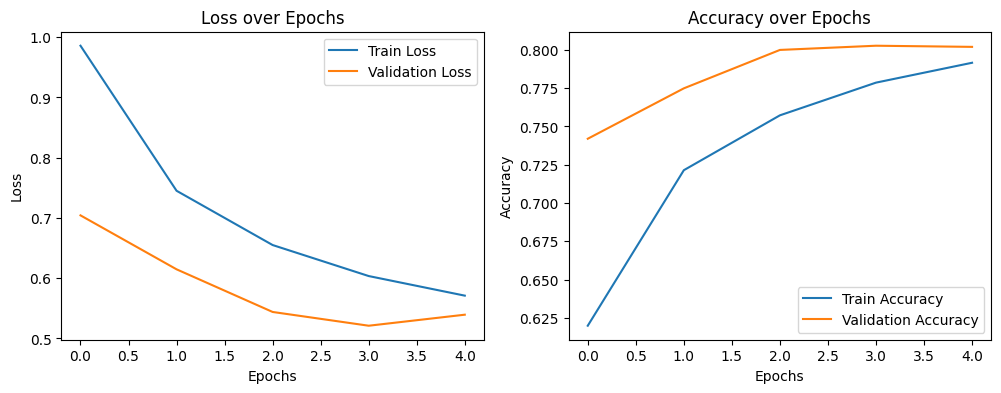

In [ ]:
#Entraînement du modèle
import datetime
import pytz
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les chemins d'accès pour les ensembles d'entraînement et de test
train_path = "/content/augmented_dataset/train/"
test_path = "/content/augmented_dataset/test/"

# Paramètres des images
img_width = 150
img_height = 150
batch_size = 32

# Création des générateurs d'images avec augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Préparation des générateurs
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

# Modèle - CNN
# ------------------------------
hiperparameters = {
    'batch_size': batch_size,
    'epochs': 5
}

# Architecture du modèle CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_width, img_height, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
a = datetime.datetime.now(pytz.timezone("America/Montreal"))
print(a)
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=hiperparameters['epochs']
)
b = datetime.datetime.now(pytz.timezone("America/Montreal"))
print(b)

print(f"Training time: {b - a}")
# Évaluer le modèle
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Sauvegarder le modèle entraîné
model_save_path = "/content/saved_model"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Visualiser les courbes de perte et de précision
plt.figure(figsize=(12, 4))

# Courbe de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
